### Rohlik Orders Forecasting Challenge
#### Use historical data to predict customer orders


### Overview
Rohlik Group, a leading European e-grocery innovator, is revolutionising the food retail industry. We operate across 11 warehouses in Czech Republic, Germany, Austria, Hungary, and Romania.
Our challenge focuses on predicting the number of orders (grocery deliveries) at selected warehouses for the next 60 days.

In [53]:
# for analysis and data processing
import pandas as pd
import numpy as np
import seaborn as sns
import ppscore as pps
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
# for modelling
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
#from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [75]:
def read_data(path_to_csv_file):
    '''
    Reads csv files from specified paths

    Parameters:
            path to csv file locations
    Returns:
            dataframes of imported csv files
    '''
    # Read CSV files
    df = pd.read_csv(path_to_csv_file)
    
    return df

# call the function to import train data - update with relevant paths
train = read_data('/Users/mncedisimncwabe/Downloads/train.csv')
test = read_data('/Users/mncedisimncwabe/Downloads/test.csv')
train_calendar = read_data('/Users/mncedisimncwabe/Downloads/train_calendar.csv')
test_calendar = read_data('/Users/mncedisimncwabe/Downloads/test_calendar.csv')


In [4]:
def df_snapshot(df):
    '''
    Returns top 5 rows of the dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return display(df.head())

print(f'train:')
df_snapshot(train)
print(f'test:')
df_snapshot(test)
print(f'train_calendar:')
df_snapshot(train_calendar)
print(f'test_Calendar:')
df_snapshot(test_calendar)

train:


,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


test:


,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,NaN,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,NaN,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,2024-03-19,NaN,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,2024-03-20,NaN,0,0,0,0,Prague_1_2024-03-20


train_calendar:


,date,holiday_name,holiday,shutdown,mini_shutdown,warehouse_limited,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,warehouse
0,2022-03-09,NaN,0,0,0,0,0,1,0,0,0.0,0,0.0,0.0,Prague_1
1,2019-07-03,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
2,2020-05-18,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
3,2021-11-09,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
4,2023-08-02,NaN,0,0,0,0,0,0,0,0,0.0,0,2.5,0.0,Prague_1


test_Calendar:


,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2024-11-17,Den boje za svobodu a demokracii,1,0,0,0,Prague_1
1,2024-07-04,NaN,0,0,0,0,Prague_1
2,2024-08-04,NaN,0,0,0,0,Prague_1
3,2024-12-01,NaN,0,0,0,0,Prague_1
4,2024-07-24,NaN,0,0,0,0,Prague_1


In [5]:
def data_types(df):
    '''
    Returns datatype of fields in a dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return df.info()

print(f'train:')
data_types(train)
print(f'test:')
data_types(test)

train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7340 non-null   object 
 1   date                    7340 non-null   object 
 2   orders                  7340 non-null   float64
 3   holiday_name            218 non-null    object 
 4   holiday                 7340 non-null   int64  
 5   shutdown                7340 non-null   int64  
 6   mini_shutdown           7340 non-null   int64  
 7   shops_closed            7340 non-null   int64  
 8   winter_school_holidays  7340 non-null   int64  
 9   school_holidays         7340 non-null   int64  
 10  blackout                7340 non-null   int64  
 11  mov_change              7340 non-null   float64
 12  frankfurt_shutdown      7340 non-null   int64  
 13  precipitation           7070 non-null   float64
 14  snow                    7070 non-

In [76]:
def convert_event_time_to_datetime(df,column):
    """
    Returns a dataframe with converted event_timestamp field from object to datetime
    
    Parameters:
        df (DataFrame): Pandas dataframe
        column (Object): Object field to datetime
    
    """
    df[column] = pd.to_datetime(df[column])
    
    return df

# convert in train
convert_event_time_to_datetime(train,'date')
convert_event_time_to_datetime(test,'date')
convert_event_time_to_datetime(train_calendar,'date')
convert_event_time_to_datetime(test_calendar,'date')

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2024-11-17,Den boje za svobodu a demokracii,1,0,0,0,Prague_1
1,2024-07-04,NaN,0,0,0,0,Prague_1
2,2024-08-04,NaN,0,0,0,0,Prague_1
3,2024-12-01,NaN,0,0,0,0,Prague_1
4,2024-07-24,NaN,0,0,0,0,Prague_1
...,...,...,...,...,...,...,...
1864,2024-08-16,NaN,0,0,0,0,Budapest_1
1865,2024-08-20,State Foundation Day,1,1,0,0,Budapest_1
1866,2024-03-16,NaN,0,0,0,0,Budapest_1
1867,2024-05-21,National Defense Day,0,0,0,0,Budapest_1


In [9]:
def null_checker(df):
    '''
    Returns the count of rows found in the data frame where there is a null present.

    Parameters:
        df (Dataframe): Pandas dataframe

    Returns:
        Prints the null count, null percentage, and row count per column.
    '''
    row_count = len(df)
    null_counts = df.isnull().sum().sort_values(ascending=False)
    null_percentages = (null_counts / row_count) * 100
    combined = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])
    combined['Row Count'] = row_count
    print(combined)

# check nulls in train
print(f'train:')
null_checker(train)
print(f'test:')
null_checker(test)

train:
                        Null Count  Null Percentage  Row Count
snow                           270         3.678474       7340
precipitation                  270         3.678474       7340
warehouse                        0         0.000000       7340
blackout                         0         0.000000       7340
user_activity_2                  0         0.000000       7340
user_activity_1                  0         0.000000       7340
frankfurt_shutdown               0         0.000000       7340
mov_change                       0         0.000000       7340
school_holidays                  0         0.000000       7340
date                             0         0.000000       7340
winter_school_holidays           0         0.000000       7340
shops_closed                     0         0.000000       7340
mini_shutdown                    0         0.000000       7340
shutdown                         0         0.000000       7340
holiday                          0         0.000

In [77]:
train = train.drop('holiday_name',axis=1)
test = test.drop('holiday_name',axis=1)

train_calendar = train_calendar.drop('holiday_name',axis=1)
test_calendar = test_calendar.drop('holiday_name',axis=1)

In [10]:
train.describe()

,date,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2
count,7340,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7070.000000,7070.000000,7340.000000,7340.000000
mean,2022-08-27 18:17:27.629427968,5535.443869,0.027248,0.000136,0.000545,0.010899,0.029973,0.007084,0.000954,0.221499,0.000272,1.621126,0.290112,1633.545777,23477.031335
min,2020-12-05 00:00:00,790.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,482.000000,1797.000000
25%,2021-11-23 00:00:00,4434.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,945.000000,18509.000000
50%,2022-09-08 00:00:00,5370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1349.000000,22267.000000
75%,2023-06-13 06:00:00,7009.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2308.000000,30028.750000
max,2024-03-15 00:00:00,18139.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,19.840000,3437.000000,45769.000000
std,NaN,2182.680279,0.162816,0.011672,0.023340,0.103836,0.170524,0.083876,0.030869,0.410293,0.016506,4.542875,1.546102,784.167637,8934.848328


In [78]:
train['precipitation'].fillna(train['precipitation'].median(), inplace=True)
train['snow'].fillna(train['snow'].median(), inplace=True)


train_calendar['precipitation'].fillna(train_calendar['precipitation'].median(), inplace=True)
train_calendar['snow'].fillna(train_calendar['snow'].median(), inplace=True)


In [80]:
train_merged.head()

,warehouse_x,date,orders,holiday_x,shutdown_x,mini_shutdown_x,shops_closed_x,winter_school_holidays_x,school_holidays_x,blackout_x,...,warehouse_limited,shops_closed_y,winter_school_holidays_y,school_holidays_y,blackout_y,mov_change_y,frankfurt_shutdown_y,precipitation_y,snow_y,warehouse_y
0,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
1,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,Brno_1
2,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,Prague_2
3,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,Prague_3
4,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,Munich_1


In [82]:
# Merge the train and calendar data with custom suffixes
train_merged = pd.merge(train, train_calendar, on='date', how='left', suffixes=('_train', '_calendar'))
test_merged = pd.merge(test, test_calendar, on='date', how='left', suffixes=('_test', '_calendar'))

# Handle missing values (if any)
train_merged.fillna(0, inplace=True)
test_merged.fillna(0, inplace=True)

# Display the first few rows to confirm
train_merged.head()

,warehouse_train,date,orders,holiday_train,shutdown_train,mini_shutdown_train,shops_closed_train,winter_school_holidays_train,school_holidays_train,blackout_train,...,warehouse_limited,shops_closed_calendar,winter_school_holidays_calendar,school_holidays_calendar,blackout_calendar,mov_change_calendar,frankfurt_shutdown_calendar,precipitation_calendar,snow_calendar,warehouse_calendar
0,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
1,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,Brno_1
2,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,Prague_2
3,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,Prague_3
4,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,Munich_1


In [85]:
#Drop columns that are not needed or have the same information as other columns
train_merged.drop(['warehouse_calendar'], axis=1, inplace=True)
test_merged.drop([ 'warehouse_calendar'], axis=1, inplace=True)

In [86]:
# Encode categorical features
train_merged = pd.get_dummies(train_merged, columns=['warehouse_train'])
test_merged = pd.get_dummies(test_merged, columns=['warehouse_test'])

In [87]:

# Ensure the same columns in test and train data
missing_cols = set(train_merged.columns) - set(test_merged.columns)
for col in missing_cols:
    test_merged[col] = 0

# Align the columns in the same order
test_merged = test_merged[train_merged.columns.drop('orders')]

# Prepare the training data
X_train = train_merged.drop(['orders', 'date', 'id'], axis=1)
y_train = train_merged['orders']

# Prepare the test data
X_test = test_merged.drop(['date', 'id'], axis=1)

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import numpy as np

def model_application(X_train, y_train, optimiser):
    '''
    Model application. If optimiser is true, a randomized search is applied to optimise the model. 
    If optimiser is false, the base model is used.

    '''
    if optimiser:
        # Define the parameters for randomized search
        params = {
            'max_features': [1, 3],
            'min_samples_split': [2, 3],
            'min_samples_leaf': [1, 3],
            'criterion': ["squared_error", "absolute_error"]
        }

        # Using K-fold cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=15)

        # Building the model
        rf = RandomForestRegressor()

        # Create custom scoring function for MAPE
        mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

        # Parameter estimation using RandomizedSearch
        grid = RandomizedSearchCV(rf, param_distributions=params, scoring=mape_scorer, n_jobs=-1, cv=cv, verbose=1, n_iter=50, random_state=42)
        
        # Fitting the model
        grid.fit(X_train, y_train)

        best_score = grid.best_score_
        print('Best Score:', best_score)
        print('Best Params:', grid.best_params_)
        print('Best Estimator:', grid.best_estimator_)

        rf_reg = grid.best_estimator_
    else:
        rf_reg = RandomForestRegressor(n_estimators=150,
                                       max_depth=16,
                                       criterion='squared_error',
                                       min_samples_split=10,
                                       max_leaf_nodes=20,
                                       max_features=0.5,
                                       bootstrap=True)
        rf_reg.fit(X_train, y_train)

    return rf_reg

# Example usage:
optimiser = False  # Set to True to apply randomized search with MAPE as the evaluation metric
rf_reg = model_application(X_train, y_train, optimiser)

In [106]:
def model_predict(rf, X_test):
    """
    Create y_pred, model prediction based on test set features.
    """
    y_pred = rf.predict(X_test)
    return y_pred

y_pred = model_predict(rf_reg, X_test)

# Since we don't have y_test in the provided files, we'll assume y_test is part of the original train dataset split
# Let's assume an 80-20 train-test split here just for evaluation purpose
train_size = int(0.8 * len(train_merged))
X_train_split = X_train[:train_size]
X_test_split = X_train[train_size:]
y_train_split = y_train[:train_size]
y_test_split = y_train[train_size:]

# Print R-squared for training and test sets
print('Training R-squared Score (%):', rf_reg.score(X_train_split, y_train_split) * 100)
print('Test R-squared Score (%):', rf_reg.score(X_test_split, y_test_split) * 100)

# Predict on the test split and evaluate metrics
y_pred_split = model_predict(rf_reg, X_test_split)
mse = mean_squared_error(y_test_split, y_pred_split)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(y_test_split, y_pred_split)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Percentage Error:', mape)

Training R-squared Score (%): 94.1790941936703
Test R-squared Score (%): 95.76319055128215
Mean Squared Error: 125354.80864829663
Root Mean Squared Error: 354.05481023182926
Mean Absolute Percentage Error: 0.05822096502152554


In [94]:
X_train_split.head()

,holiday_train,shutdown_train,mini_shutdown_train,shops_closed_train,winter_school_holidays_train,school_holidays_train,blackout_train,mov_change_train,frankfurt_shutdown_train,precipitation_train,...,frankfurt_shutdown_calendar,precipitation_calendar,snow_calendar,warehouse_train_Brno_1,warehouse_train_Budapest_1,warehouse_train_Frankfurt_1,warehouse_train_Munich_1,warehouse_train_Prague_1,warehouse_train_Prague_2,warehouse_train_Prague_3
0,0,0,0,0,0,0,0,0.0,0,0.0,...,0,0.0,0.0,False,False,False,False,True,False,False
1,0,0,0,0,0,0,0,0.0,0,0.0,...,0,0.0,0.0,False,False,False,False,True,False,False
2,0,0,0,0,0,0,0,0.0,0,0.0,...,0,0.0,0.0,False,False,False,False,True,False,False
3,0,0,0,0,0,0,0,0.0,0,0.0,...,0,0.0,0.0,False,False,False,False,True,False,False
4,0,0,0,0,0,0,0,0.0,0,0.0,...,0,0.0,0.0,False,False,False,False,True,False,False


In [103]:
# Generate predictions for test data using test_merged
test_predictions = rf_reg.predict(X_test)

# Ensure 'id' is the unique identifier to match original test rows with predictions
# Creating a DataFrame to hold predictions with corresponding ids
predictions_df = pd.DataFrame({'id': test_merged['id'], 'orders': test_predictions})

# Drop duplicates to keep only unique identifiers
predictions_df = predictions_df.drop_duplicates(subset='id')

# Merge the predictions with the original test DataFrame based on 'id'
test_with_predictions = pd.merge(test, predictions_df[['id', 'orders']], on='id', how='left')

# Display the first few rows of the resulting DataFrame
test_with_predictions.head()

# Check for duplicates in the merged DataFrame
test_with_predictions = test_with_predictions.drop_duplicates(subset='id')

# Display the shape of the resulting DataFrame
test_with_predictions.shape


(397, 8)

In [104]:
test_with_predictions.head()

,warehouse,date,holiday,shops_closed,winter_school_holidays,school_holidays,id,orders
0,Prague_1,2024-03-16,0,0,0,0,Prague_1_2024-03-16,2151.406264
1,Prague_1,2024-03-17,0,0,0,0,Prague_1_2024-03-17,2151.406264
2,Prague_1,2024-03-18,0,0,0,0,Prague_1_2024-03-18,2151.406264
3,Prague_1,2024-03-19,0,0,0,0,Prague_1_2024-03-19,2151.406264
4,Prague_1,2024-03-20,0,0,0,0,Prague_1_2024-03-20,2151.406264


In [105]:
test_with_predictions[['id','orders']].to_csv('/Users/mncedisimncwabe/Downloads/orders_predictions.csv', index=False)
print("Submission file created successfully")

Submission file created successfully


In [12]:
print(train['date'].min()),
print(train['date'].max())
print(test['date'].min()),
print(test['date'].max())

2020-12-05 00:00:00
2024-03-15 00:00:00
2024-03-16 00:00:00
2024-05-15 00:00:00


In [13]:
train.head()

,warehouse,date,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


In [14]:
train['warehouse'].unique()

array(['Prague_1', 'Brno_1', 'Prague_2', 'Prague_3', 'Munich_1',
       'Frankfurt_1', 'Budapest_1'], dtype=object)

In [10]:
# Separating numerical and categorical features (excluding 'Name', 'Ticket', and 'PassengerId')
numerical_features = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train.select_dtypes(include=[object]).columns.tolist()

# Columns to exclude
exclude_columns = ['date', 'id']

# Remove excluded columns from numerical and categorical lists
numerical_features = [col for col in numerical_features if col not in exclude_columns]
categorical_features = [col for col in categorical_features if col not in exclude_columns]

# Define the specific columns for numerical and categorical features
numerical_specific = ['precipitation', 'user_activity_1', 'user_activity_2', 'orders']
categorical_specific = [col for col in categorical_features if col not in numerical_specific + exclude_columns]

# Adjust the lists according to your requirements
numerical_features = [col for col in numerical_features if col in numerical_specific]
categorical_features = [col for col in categorical_features if col not in numerical_specific and col not in ['precipitation', 'user_activity_1', 'user_activity_2', 'orders']]

In [31]:
# Columns to exclude from categorical features
exclude_columns = ['date', 'id', 'precipitation', 'user_activity_1', 'user_activity_2', 'orders','snow']

# Define the specific columns for numerical and categorical features
numerical_features = ['precipitation','snow', 'user_activity_1', 'user_activity_2', 'orders']
categorical_features = [col for col in train.columns.tolist() if col not in exclude_columns]

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'orders']
Categorical features: ['warehouse', 'holiday', 'shutdown', 'mini_shutdown', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown']


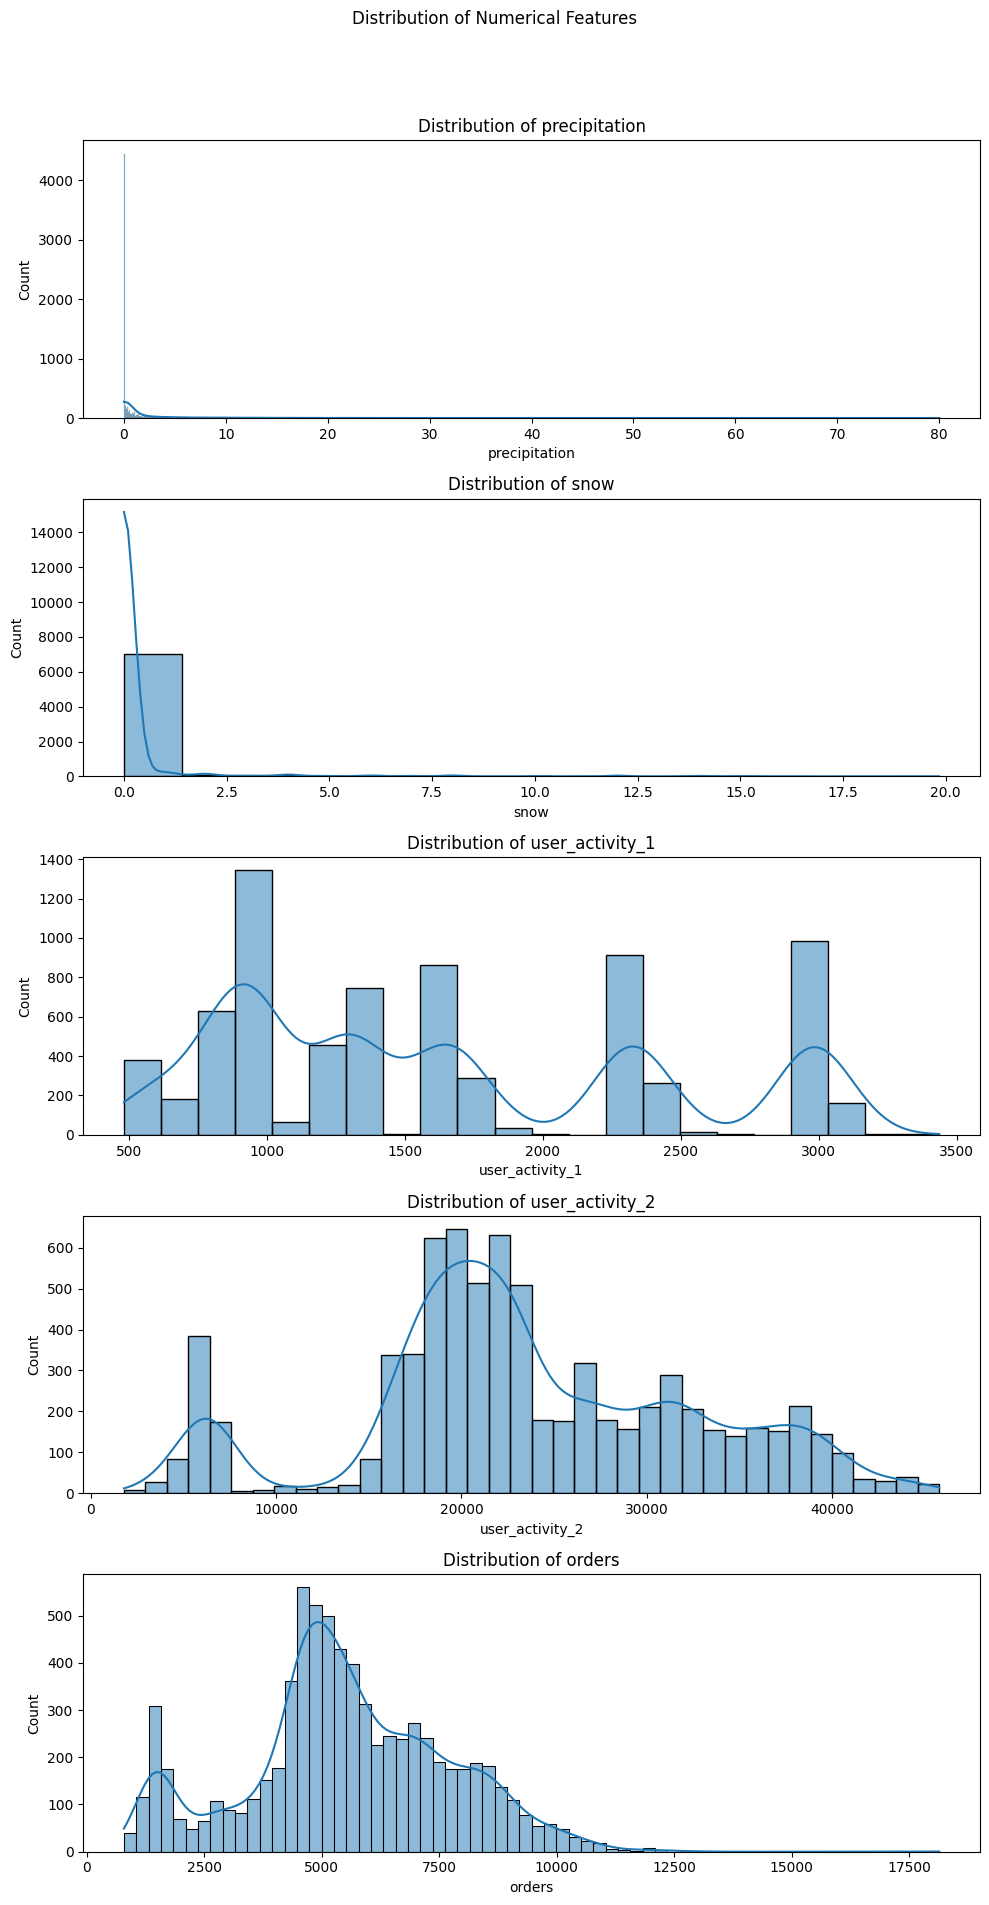

In [28]:
# Visualizing the distribution of numerical features
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(10, 20))
fig.suptitle('Distribution of Numerical Features')

for i, col in enumerate(numerical_features):
    sns.histplot(train[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

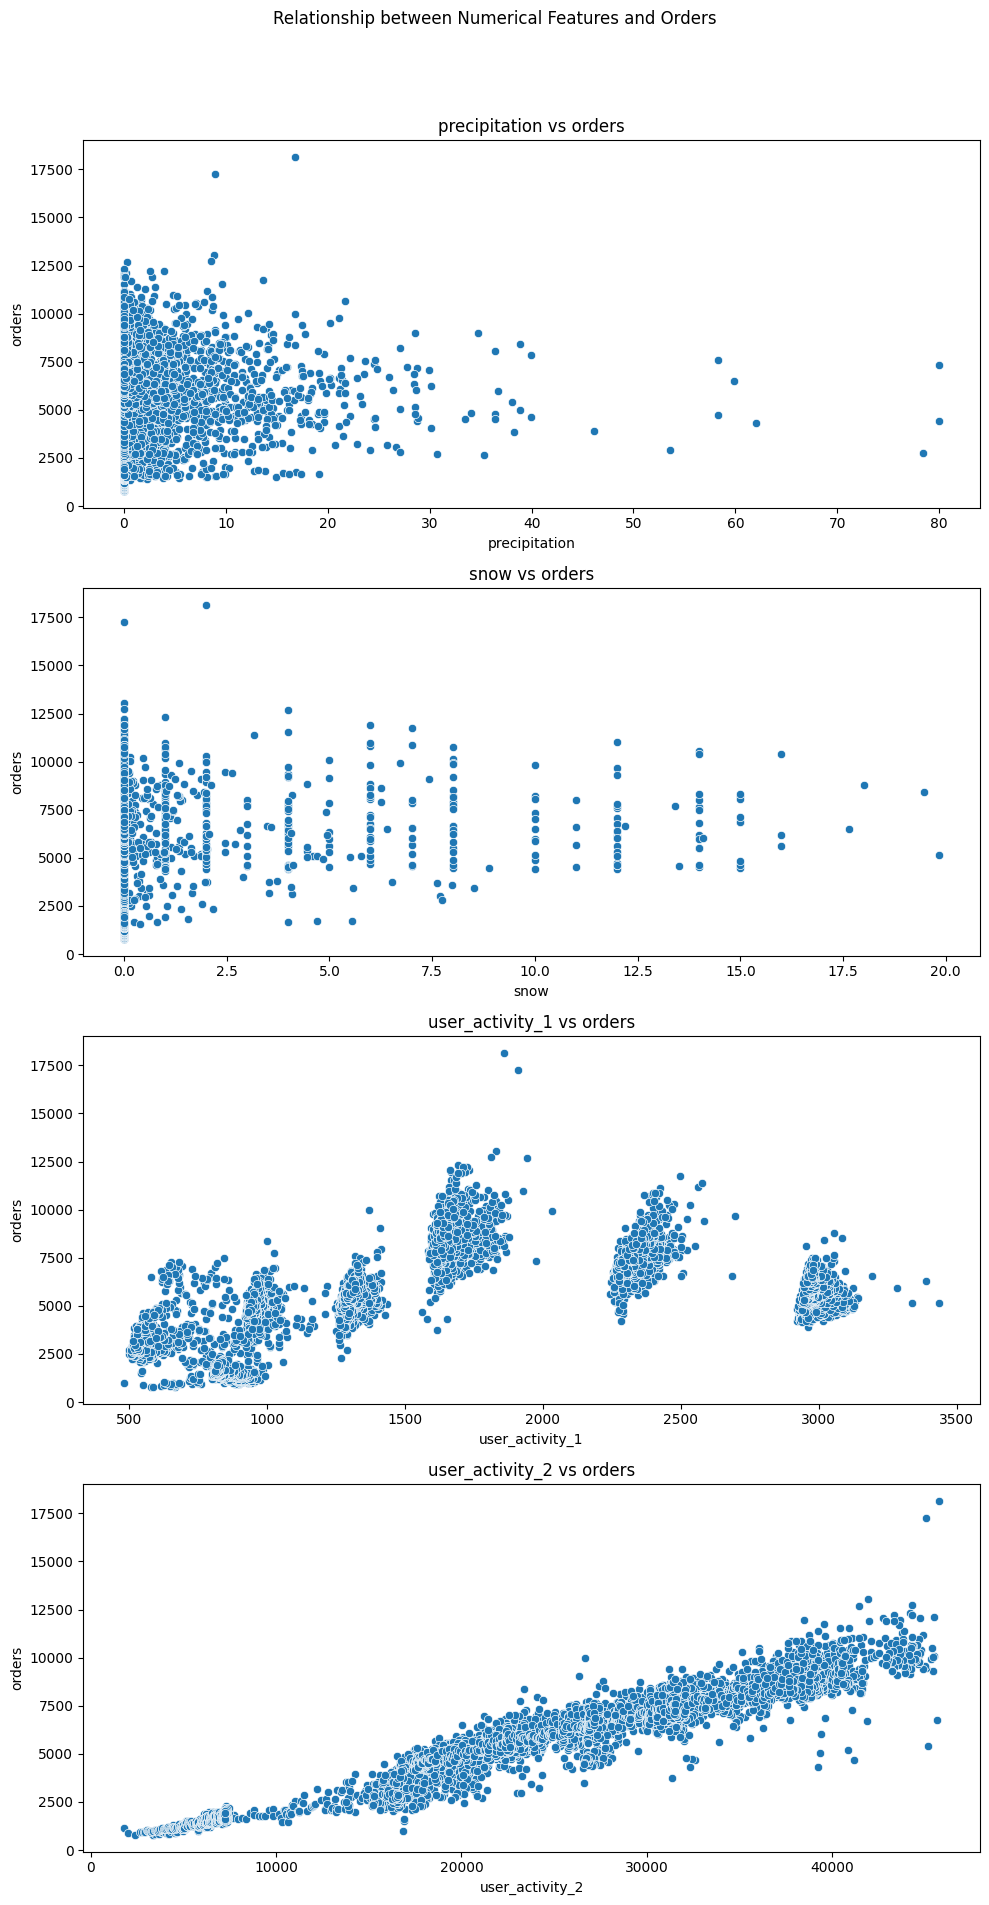

In [29]:
# Remove 'orders' from numerical features as it's the target variable
numerical_features.remove('orders')

# Visualizing the relationship between numerical features and the continuous target variable 'orders'
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(10, 20))
fig.suptitle('Relationship between Numerical Features and Orders')

# If there is only one subplot, axes is not a list, so we need to convert it to a list
if len(numerical_features) == 1:
    axes = [axes]

for i, col in enumerate(numerical_features):
    sns.scatterplot(x=train[col], y=train['orders'], ax=axes[i])
    axes[i].set_title(f'{col} vs orders')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

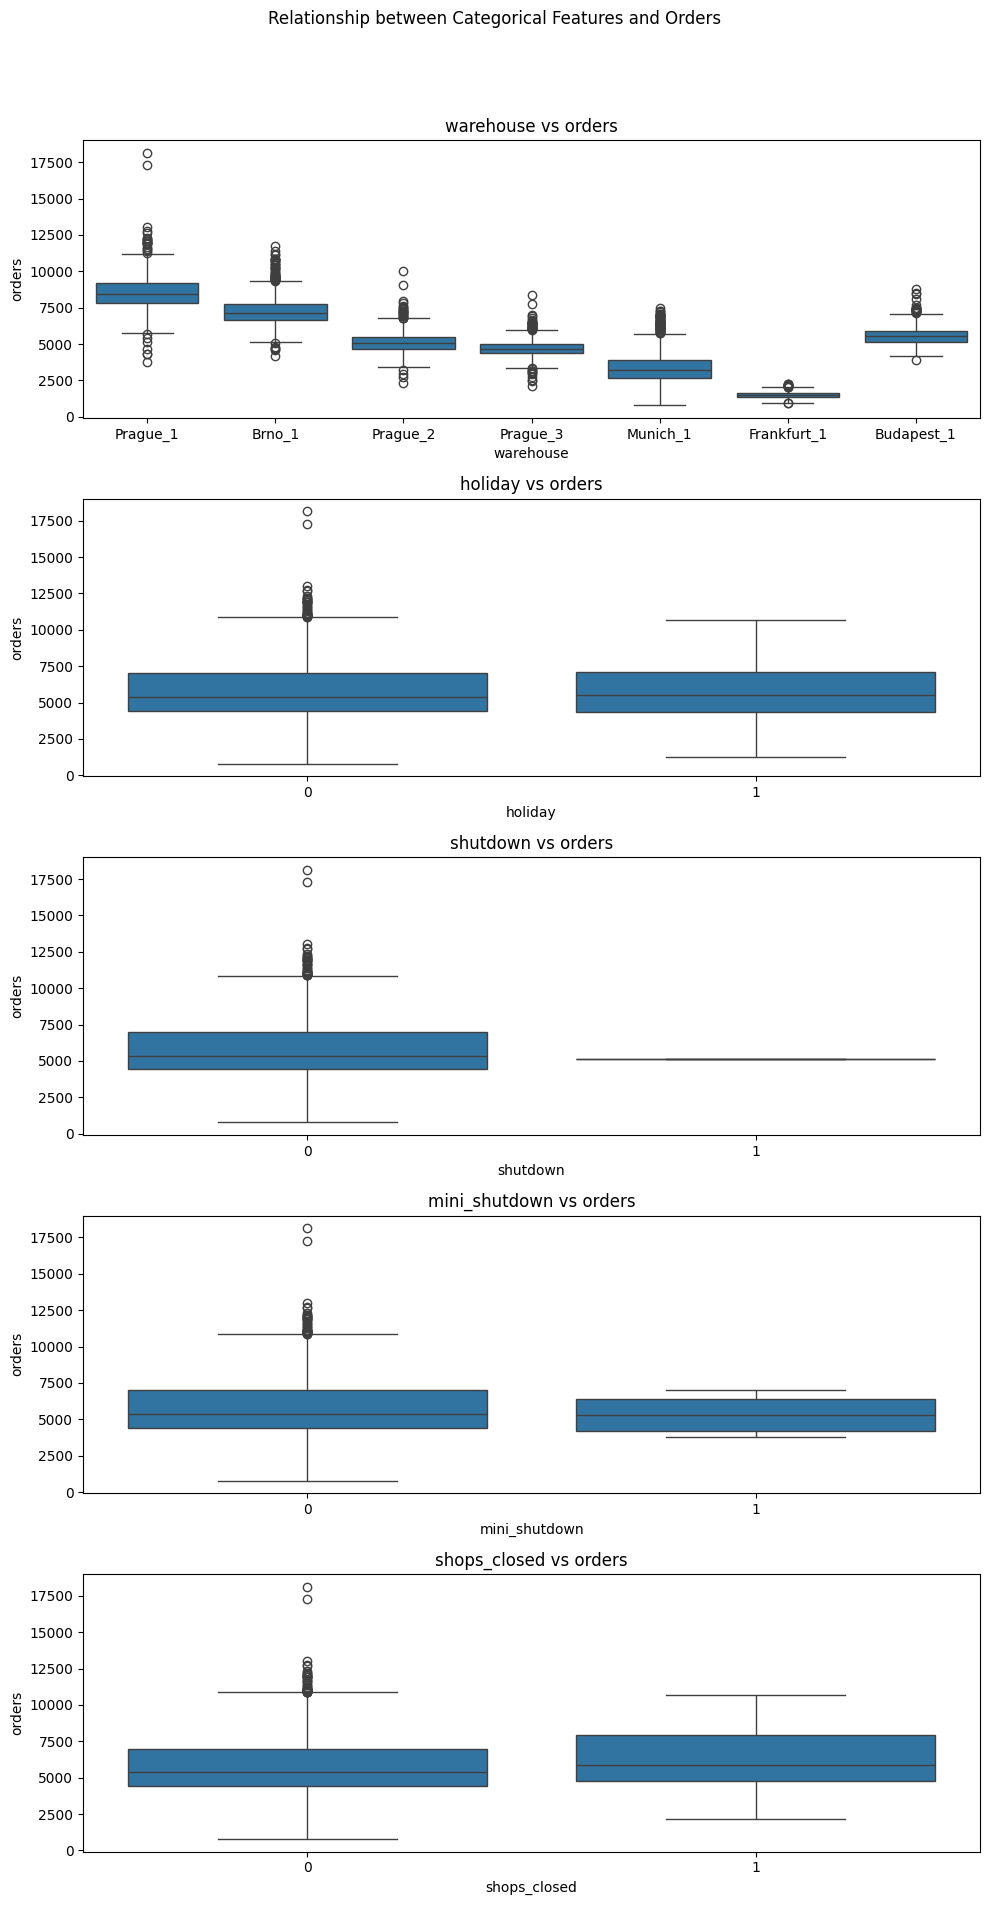

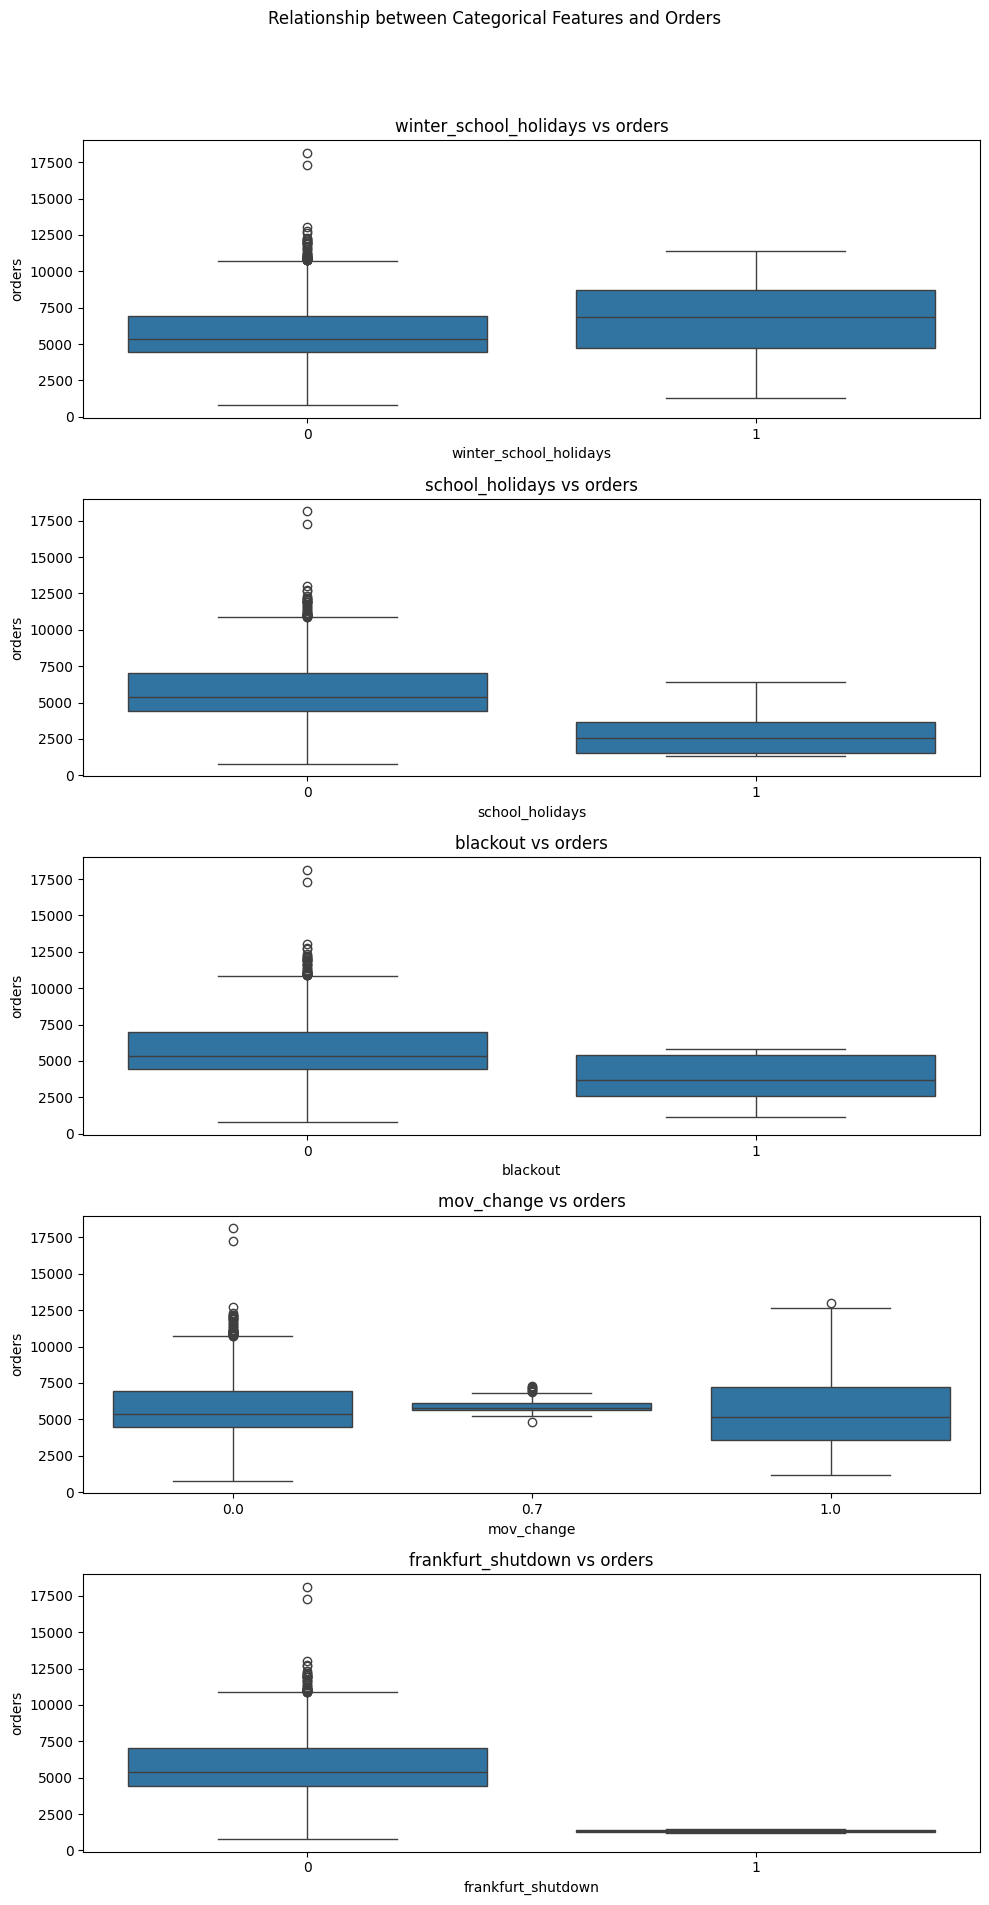

In [32]:
# Define batch size for plots
batch_size = 5

# Loop through categorical features in batches
for start in range(0, len(categorical_features), batch_size):
    end = start + batch_size
    batch_features = categorical_features[start:end]
    
    fig, axes = plt.subplots(nrows=len(batch_features), ncols=1, figsize=(10, len(batch_features) * 4))
    fig.suptitle('Relationship between Categorical Features and Orders')

    # If there is only one subplot, axes is not a list, so we need to convert it to a list
    if len(batch_features) == 1:
        axes = [axes]

    for i, col in enumerate(batch_features):
        sns.boxplot(x=train[col], y=train['orders'], ax=axes[i])
        axes[i].set_title(f'{col} vs orders')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Summary:
- Precipitation shows that most orders occur at lower precipitation levels, with a few high-value outliers at these levels.
- User Activity 1 demonstrates segmented user behaviors, with higher activity levels generally correlating with higher order volumes.
- User Activity 2 has a strong positive correlation with orders, making it a critical feature for predicting order volume.
- Warehouse locations influence order distributions significantly, with some warehouses handling higher and more variable order volumes than others.
- Impact of Holidays and Shutdowns: Both holidays and shutdown periods affect order volumes, with holidays showing a slight decrease and shutdowns (both full and mini) having a more substantial impact. Businesses should prepare for these fluctuations to maintain service levels.
- Shop Closures: Closing shops has a moderate impact on order volumes, emphasizing the need to strengthen other sales channels during these times.


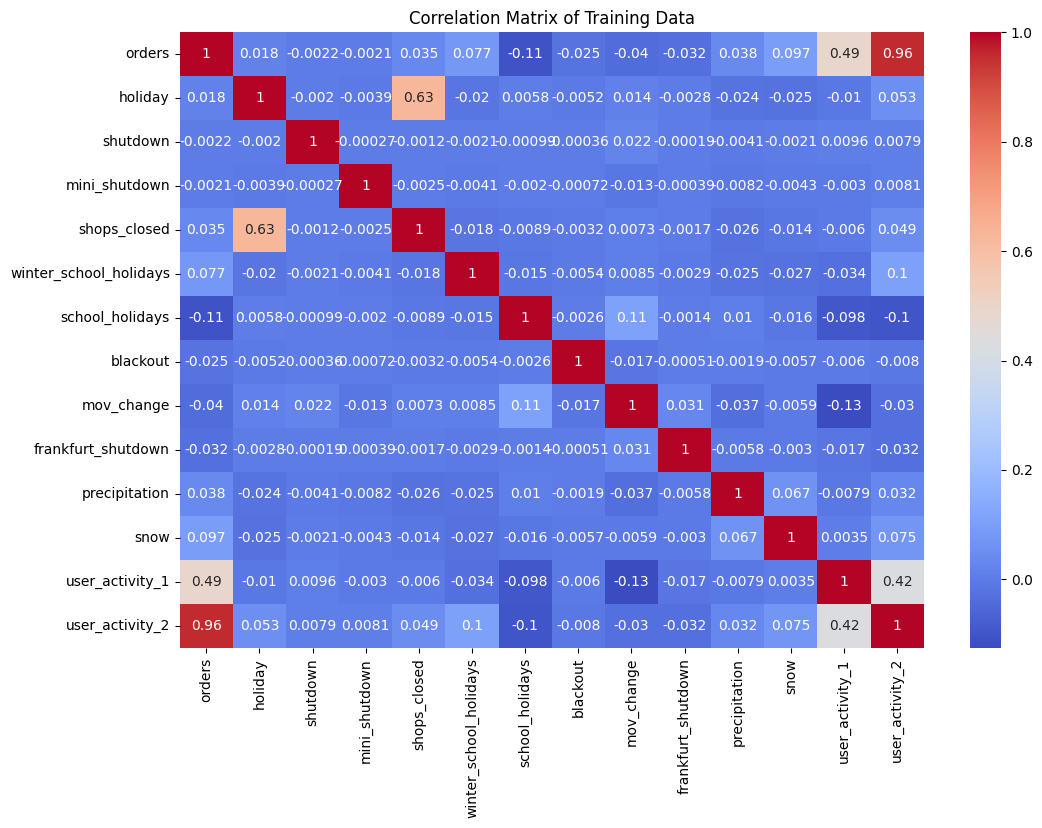

In [38]:
# Correlation matrix
lee = train.drop(['date','warehouse','id'],axis=1)
lee = lee.corr()

# Plotting correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(lee, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Training Data")
plt.show()

Overall, user activities play a critical role in predicting orders, with strong correlations observed. Seasonal and operational factors like holidays and snow have smaller but noticeable impacts. This correlation matrix provides valuable insights for refining predictive models and making data-driven operational decisions.

In [42]:
test = test.drop(['date','warehouse'],axis=1)
train_df = train[['orders','holiday','shops_closed','winter_school_holidays','school_holidays','id']]

In [43]:
train_df.head()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,6895.0,0,0,0,0,Prague_1_2020-12-05
1,6584.0,0,0,0,0,Prague_1_2020-12-06
2,7030.0,0,0,0,0,Prague_1_2020-12-07
3,6550.0,0,0,0,0,Prague_1_2020-12-08
4,6910.0,0,0,0,0,Prague_1_2020-12-09


In [44]:
test.head()

,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,0,0,0,0,Prague_1_2024-03-16
1,0,0,0,0,Prague_1_2024-03-17
2,0,0,0,0,Prague_1_2024-03-18
3,0,0,0,0,Prague_1_2024-03-19
4,0,0,0,0,Prague_1_2024-03-20


In [48]:
def calculate_predictive_power(df, target):
    """
    Calculates the predictive power score (PPS) for variables in a dataframe against a target variable.
    
    """
    predictors_df = pps.predictors(df, target)
    sorted_predictors = predictors_df.sort_values(by="ppscore", ascending=False)
    
    return sorted_predictors

predictors_df = calculate_predictive_power(train_df, "orders")
predictors_df

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,school_holidays,orders,0.002953,regression,True,mean absolute error,1715.2976,1710.232155,DecisionTreeRegressor()
1,holiday,orders,0.000000,regression,True,mean absolute error,1715.2976,1720.745941,DecisionTreeRegressor()
2,shops_closed,orders,0.000000,regression,True,mean absolute error,1715.2976,1719.921049,DecisionTreeRegressor()
3,winter_school_holidays,orders,0.000000,regression,True,mean absolute error,1715.2976,1717.999067,DecisionTreeRegressor()
4,id,orders,0.000000,feature_is_id,True,None,0.0000,0.000000,None


In [49]:
def set_features_and_target(df):
    '''
    Returns two data frames with features and target variables.
            Parameters:
                    df (str): Pandas dataframe
    '''
    X = df.drop(['id','orders'], axis=1)
    y = df['orders']
    
    return X,y
                 
X,y = set_features_and_target(train_df)
print(X.shape, y.shape)

(7340, 4) (7340,)


In [52]:
def train_test_split_df(X,y):
    '''
    Creates train and test split.

    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_df(X,y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(5872, 4) (5872,)
(1468, 4) (1468,)


In [60]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

def model_application(X_train, y_train, optimiser):
    '''
    Model application. If optimiser is true, a grid search is applied to optimise the model. 
    If optimiser is false, the base model is used.

    '''
    if optimiser:
        # Define the parameters for grid search
        params = {
            'max_features': [1, 3, 10, 0.5],
            'min_samples_split': [2, 3, 10],
            'min_samples_leaf': [1, 3, 10],
            'criterion': ["squared_error", "absolute_error"]
        }

        # Using K-fold cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=15)

        # Building the model
        rf = RandomForestRegressor()

        # Create custom scoring function for MAPE
        mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

        # Parameter estimation using GridSearch
        grid = GridSearchCV(rf, param_grid=params, scoring=mape_scorer, n_jobs=-1, cv=cv, verbose=1)
        
        # Fitting the model
        grid.fit(X_train, y_train)

        best_score = grid.best_score_
        print('Best Score:', best_score)
        print('Best Params:', grid.best_params_)
        print('Best Estimator:', grid.best_estimator_)

        rf_reg = grid.best_estimator_
    else:
        rf_reg = RandomForestRegressor(n_estimators=150,
                                       max_depth=16,
                                       criterion='squared_error',
                                       min_samples_split=10,
                                       max_leaf_nodes=20,
                                       max_features=0.5,
                                       bootstrap=True)
        rf_reg.fit(X_train, y_train)

    return rf_reg

# Example usage:
optimiser = True  # Set to True to apply grid search with MAPE as the evaluation metric
rf_reg = model_application(X_train, y_train, optimiser)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Score: -0.48634896047342735
Best Params: {'criterion': 'absolute_error', 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 10}
Best Estimator: RandomForestRegressor(criterion='absolute_error', max_features=1,
                      min_samples_leaf=3, min_samples_split=10)


In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def model_predict(rf, X_test):
    """
    Create y_pred, model prediction based on test set features.
    """
    y_pred = rf.predict(X_test)
    return y_pred

y_pred = model_predict(rf_reg, X_test)

# Print R-squared for training and test sets
print('Training R-squared Score (%):', rf_reg.score(X_train, y_train) * 100)
print('Test R-squared Score (%):', rf_reg.score(X_test, y_test) * 100)

# Print other regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Percentage Error:', mape)

Training R-squared Score (%): 1.1665443876240023
Test R-squared Score (%): 0.5974931126084604
Mean Squared Error: 4752908.787674677
Root Mean Squared Error: 2180.1166912976646
Mean Absolute Percentage Error: 0.45804579938193307


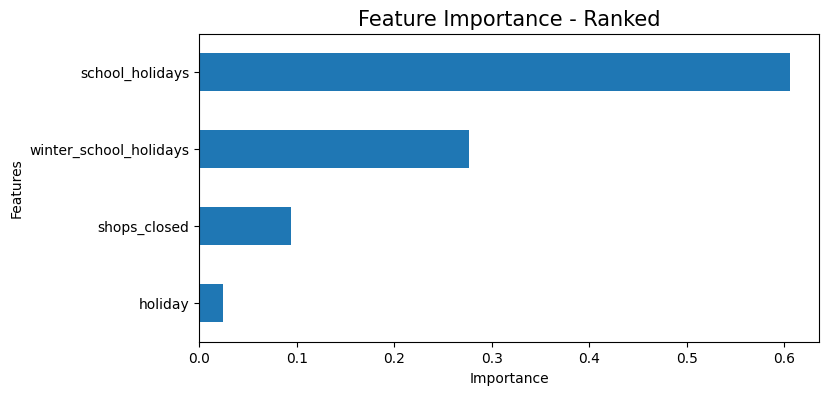

In [57]:
def plot_feature_importance(model, feature_names, n=30):
    
    '''
    Produces a plot displaying features that are most important predictors of the target feature.
            Parameters:
                    random forest model
                    feature names
    '''
    
    plt.figure(figsize=(8, 4))

    feat_importances = pd.Series(model.feature_importances_, index=feature_names)
    feat_importances.nsmallest(n).plot(kind='barh')
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title("Feature Importance - Ranked", fontsize=15)
    plt.show()

plot_feature_importance(rf_reg, X_train.columns)

In [62]:
# Predict sale prices for test data
test_predictions = rf_reg.predict(test[['holiday','shops_closed','winter_school_holidays','school_holidays']])

test['orders'] = test_predictions

# Display the first few rows of the dataframe
test.head()

,holiday,shops_closed,winter_school_holidays,school_holidays,id,orders
0,0,0,0,0,Prague_1_2024-03-16,5334.59
1,0,0,0,0,Prague_1_2024-03-17,5334.59
2,0,0,0,0,Prague_1_2024-03-18,5334.59
3,0,0,0,0,Prague_1_2024-03-19,5334.59
4,0,0,0,0,Prague_1_2024-03-20,5334.59


In [63]:
test[['id','orders']].to_csv('/Users/mncedisimncwabe/Downloads/orders_predictions.csv', index=False)
print("Submission file created successfully")

Submission file created successfully
